# [LEGALST-123] Lab 13: Intro to Model Selection Techniques


---
<img src = "http://izquotes.com/quotes-pictures/quote-essentially-all-models-are-wrong-but-some-are-useful-george-e-p-box-212711.jpg" style = "width: 500px; height: 275px;" />

**Model Selection** is a key step in the machine learning process. Generally, you will have several candidate models that you fit to your data, and must select the one that you will use on out-of-sample data. These techniques help you determine which model is the "best."

*Estimated Time: 30 minutes*

---

**Dependencies:**

In [1]:
import numpy as np
import scipy
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

## The Data: Bike Sharing

We'll be using the same bike sharing data as last week!

In [2]:
bike= pd.read_csv(('data/Bike-Sharing-Dataset/day.csv'))

# reformat the date column to integers representing the day of the year, 001-366
bike['dteday'] = pd.to_datetime(bike['dteday']).dt.strftime('%j')

# get rid of the index column
bike = bike.drop("instant", axis = 1)

bike.head(4)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562


## 1. Test-Train-Validation Split

Recall that we typically want to split our data into training, validation, and test sets for the purposes of developing and tweaking our Machine Learning models. Below we reproduce the code from last lab:

In [3]:
# the features used to predict riders
X = bike.drop(columns=['casual', 'registered', 'cnt'])

# the number of riders
y = bike['cnt']

# set the random seed

np.random.seed(10)

# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

# split the data
# Returns 4 values: X_train, X_validate, y_train, y_validate

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

## 2. Specify Regression Models

Specify the linear regression, ridge, and lasso models that we explored in the last labs. This time you don't need to report the coefficients or plot the results.

In [4]:
# Linear Regression

## Create lin_reg method and fit model
lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)

# Ridge

## Create ridge_reg method and fit model
ridge_reg = Ridge() 
ridge_model = ridge_reg.fit(X_train, y_train)

# LASSO

## Create lasso_reg and fit
lasso_reg = Lasso(max_iter=10000)  
lasso_model = lasso_reg.fit(X_train, y_train)

## 3. Information Criterion Approaches

We now have three candidate models! First, let's implement the AIC and BIC approaches. Write code that calculates the AIC and BIC for each of the models. The (simplified) formulas for each are: 

$AIC = 2k - 2ln(sse)$

$BIC = n*ln(sse/n) + k*ln(n)$

Where $k$ is the number of features, $n$ is the number of observations, $ln$ is the natural log (hint: use np.log), and sse is the "sum of squared errors" or the squared residuals between the predicted and actual responses.

In [5]:
len(X_train.columns)

12

In [6]:
len(X_train.index)

438

In [7]:
# Columns
k = 12
# Rows
n = 438

In [8]:
lin_reg_hat = lin_model.predict(X_train)
lin_reg_resid = y_train - lin_reg_hat
lin_reg_sse = sum(lin_reg_resid**2)

lin_AIC = 2*k - 2*np.log(lin_reg_sse)
lin_AIC

-15.166728241032025

In [9]:
ridge_reg_hat = ridge_model.predict(X_train)
ridge_reg_resid = y_train - ridge_reg_hat
ridge_reg_sse = sum(ridge_reg_resid**2)

ridge_AIC = 2*k - 2*np.log(ridge_reg_sse)
ridge_AIC

-15.201467625587611

In [10]:
lasso_reg_hat = lasso_model.predict(X_train)
lasso_reg_resid = y_train - lasso_reg_hat
lasso_reg_sse = sum(lasso_reg_resid**2)

lasso_AIC = 2*k - 2*np.log(lasso_reg_sse)
lasso_AIC

-15.17550335213452

Which model should we prefer based on the AIC? How confident are you about this choice?

Next, calculate the BIC for each model.

In [11]:
lin_BIC = n*np.log(lin_reg_sse/n) + k*np.log(n)
lin_BIC

5986.488228965647

In [12]:
ridge_BIC = n*np.log(ridge_reg_sse/n) + k*np.log(n)
ridge_BIC

5994.096154183321

In [13]:
lasso_BIC = n*np.log(lasso_reg_sse/n) + k*np.log(n)
lasso_BIC

5988.409978297093

Which model should you prefer based on the BIC? Again, how confident are you about this choice?

## 4. Cross-Validation

Next, let's try a cross-validation approach. The basic logic of cross-validation is as follows:

1. Randomly split the data into k-folds
2. Build the model on k-1 folds, then test on the last fold
3. Record prediction error
4. Cycle until each fold has served as the test set
5. The average of the errors is the cv-error

Luckily a lot of this functionality is already packaged up for us in sklearn's [cross-validation methods](http://scikit-learn.org/stable/modules/cross_validation.html). First, generate predictions for each of the models by using "cross_val_predict." Use "cv = 3" and return the r^2 score, and plot the predicted vs. actual values.

In [14]:
lin_predicted = cross_val_predict(lin_reg, X, y, cv = 3)
r2_score(y, lin_predicted)

0.7530471452965213

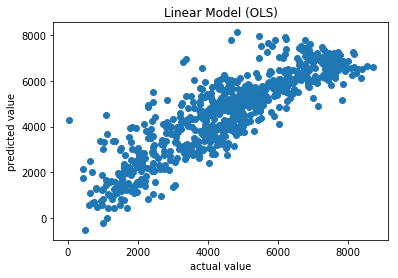

In [15]:
# plot the residuals on a scatter plot
plt.scatter(y, lin_predicted)
plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

In [16]:
ridge_predicted = cross_val_predict(ridge_reg, X, y, cv = 3)
r2_score(y, ridge_predicted)

0.7586621101488569

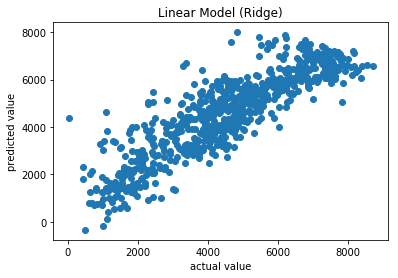

In [17]:
# plot the residuals on a scatter plot
plt.scatter(y, ridge_predicted)
plt.title('Linear Model (Ridge)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

In [18]:
lasso_predicted = cross_val_predict(lasso_reg, X, y, cv = 3)
r2_score(y, lasso_predicted)


0.7538697240957198

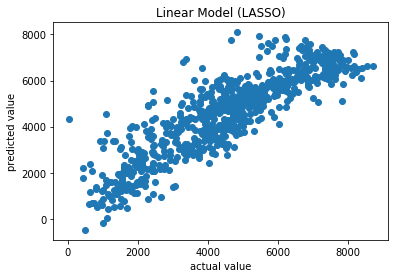

In [19]:
# plot the residuals on a scatter plot
plt.scatter(y, lasso_predicted)
plt.title('Linear Model (LASSO)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

How well does cross-validation fit the data? In general, explicitly calculating $r^2$ like this tends to overfit the data. The preferred method is to use "cross_val_score." Use "cross_val_score" to return the mean prediction from a 3-fold cross validation for each of the models. How do the $r^2$ metrics compare?

Experiment with different [metrics](http://scikit-learn.org/stable/modules/model_evaluation.html), and select your preferred model. Keep in mind that higher return values are better than lower return values in this method.

In [20]:
print(cross_val_score(lin_reg, X, y, cv=3, scoring='r2').mean())

0.5984331458110684


In [21]:
print(cross_val_score(ridge_reg, X, y, cv=3, scoring='r2').mean())

0.60821790736479


In [22]:
print(cross_val_score(lasso_reg, X, y, cv=3, scoring='r2').mean())

0.599906025528056
